In [ ]:
!pip install optuna

In [ ]:
import sys, os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import optuna
import re
from optuna.visualization import plot_slice
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.svm import SVC, LinearSVC


import xgboost as xgb
import lightgbm as lgb
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

IS_MASTER = True # Set this to True in MASTER Notebook so that it does not use the default parameters in processing notebook.
DATA_FOLDER = f'/kaggle/input/'
OUTPUT_FOLDER = f'/kaggle/working/'
DATA_REV = '2'
SYMBOL = '2024'

# PKL FILES where we save the output
X_NOSEED_OUTPUT = f'{OUTPUT_FOLDER}X_NOSEED_OUTPUT_{DATA_REV}.pkl'
X_SEED_OUTPUT = f'{OUTPUT_FOLDER}X_SEED_OUTPUT_{DATA_REV}.pkl'
LABEL_OUTPUT = f'{OUTPUT_FOLDER}LABEL_OUTPUT_{DATA_REV}.pkl'
ALL_STATISTICS_OUTPUT = f'{OUTPUT_FOLDER}ALLSTATS_{DATA_REV}.pkl'
MODEL_OUTPUT = f'{OUTPUT_FOLDER}MODEL_{DATA_REV}.pkl'
MteamDict_OUTPUT = f'{OUTPUT_FOLDER}MTEAM_DICT.pkl'
WteamDict_OUTPUT = f'{OUTPUT_FOLDER}WTEAM_DICT.pkl'

features_seed = ['EloDiff', 'AvgScoringMarginDiff', 'PythagoreanDiff', 'PtsPerPossDiff', 'WinPctDiff', \
            'EffectiveFGPctDiff', 'StealBlockFoulDiff', 'FTRateDiff', 'BArcPctDiff',
            'TORateDiff', 'DR_advDiff', 'EFG_noDiff', 'OR_advDiff', 'AssistTODiff', 'EffSmallDiff',
            'SeedDiff']

features_noseed = ['EloDiff', 'AvgScoringMarginDiff', 'PythagoreanDiff', 'PtsPerPossDiff', 'WinPctDiff', \
            'EffectiveFGPctDiff', 'StealBlockFoulDiff', 'FTRateDiff', 'BArcPctDiff',
            'TORateDiff', 'DR_advDiff', 'EFG_noDiff', 'OR_advDiff', 'AssistTODiff', 'EffSmallDiff']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Sports/NCAABB2024//march-machine-learning-mania-2024.zip
replace /content/drive/MyDrive/Sports/NCAABB2024/data/2024_tourney_seeds.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data = dict()
for filename in os.listdir(DATA_FOLDER):
    print(filename)
    try:
        data[f'{filename[:-4]}'] = pd.read_csv(DATA_FOLDER + filename, engine='python')
    except UnicodeDecodeError:
        print(filename, 'not loaded')
        continue

#
# Build Dictionaries
#
mteam = data['MTeams']
wteam = data['WTeams']

mteamdict = dict(zip(mteam['TeamID'], mteam['TeamName']))
wteamdict = dict(zip(wteam['TeamID'], wteam['TeamName']))
with open(MteamDict_OUTPUT,'wb') as f:
    pickle.dump(mteamdict,f)
with open(WteamDict_OUTPUT,'wb') as f:
    pickle.dump(wteamdict,f)



Cities.csv
Conferences.csv
MGameCities.csv
MConferenceTourneyGames.csv
2024_tourney_seeds.csv
MMasseyOrdinals.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneyCompactResults.csv
MRegularSeasonDetailedResults.csv
MTeams.csv
MSeasons.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
MTeamCoaches.csv
WGameCities.csv
WRegularSeasonCompactResults.csv
WNCAATourneyCompactResults.csv
MTeamSpellings.csv
MTeamSpellings.csv not loaded
MSecondaryTourneyTeams.csv
WNCAATourneyDetailedResults.csv
MTeamConferences.csv
MSecondaryTourneyCompactResults.csv
WRegularSeasonDetailedResults.csv
WTeamSpellings.csv
WTeamSpellings.csv not loaded
WTeamConferences.csv
WSeasons.csv
WTeams.csv
fivethirtyeight_ncaa_forecasts_2023.csv
sample_submission.csv
WTEAM_DICT.pkl
WTEAM_DICT.pkl not loaded
MTEAM_DICT.pkl
MTEAM_DICT.pkl not loaded
X_NOSEED_OUTPUT_1.pkl
X_NOSEED_OUTPUT_1.pkl not loaded
LABEL_OUTPUT_1.pkl
LABEL

In [ ]:
# ===========================================================================================
# Gather Seeding Info
# ===========================================================================================
df_seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']], ignore_index=True)

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_seeds['Seed'] = df_seeds['Seed'].apply(treat_seed)
df_seeds.info()

# ===========================================================================================
# Gather Win/Loss Info
#   * Creates df_season_results dataframe
# ===========================================================================================
men_season = data['MRegularSeasonDetailedResults']
women_season = data['WRegularSeasonDetailedResults']
men_season['Gender'] = 1
women_season['Gender'] = 0 # It's boolean, not bias
df_season_results = pd.concat([men_season, women_season])
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_season_results.head()
df_season_results[['Season', 'WTeamID', 'LTeamID', 'Gender']] = df_season_results[['Season', 'WTeamID', 'LTeamID', 'Gender']].astype(str)

# ===========================================================================================
# Gather Tournament Results Info
#   * Creates df_tourney_results dataframe
# ===========================================================================================
men_tourney = data['MNCAATourneyDetailedResults']
women_tourney = data['WNCAATourneyDetailedResults']
men_tourney['Gender'] = 1
women_tourney['Gender'] = 0
df_tourney_results = pd.concat([men_tourney, women_tourney])
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_tourney_results[['Season', 'WTeamID', 'LTeamID']] = df_tourney_results[['Season', 'WTeamID', 'LTeamID']].astype(str)
display(df_tourney_results.head())


# ===========================================================================================
# Compute Wins and Losses
#   * Creates df_features_season dataframe
# ===========================================================================================
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)

num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)

df_features_season_w = df_season_results.groupby(['Season', 'WTeamID', 'Gender']).count().reset_index()[['Season', 'WTeamID', 'Gender']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID', 'Gender']).count().reset_index()[['Season', 'LTeamID', 'Gender']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')

df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)


df_features_season['WinPct'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])

df_features_season.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098 entries, 0 to 4097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Season  4098 non-null   int64
 1   Seed    4098 non-null   int64
 2   TeamID  4098 non-null   int64
dtypes: int64(3)
memory usage: 96.2 KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
0,2003,134,1421,92,1411,84,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,1
1,2003,136,1112,80,1436,51,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,1
2,2003,136,1113,84,1272,71,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,1
3,2003,136,1141,79,1166,73,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,1
4,2003,136,1143,76,1301,74,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12857 entries, 0 to 12856
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     12857 non-null  object 
 1   TeamID     12857 non-null  object 
 2   Gender     12857 non-null  object 
 3   NumWins    12857 non-null  float64
 4   NumLosses  12857 non-null  float64
 5   WinPct     12857 non-null  float64
dtypes: float64(3), object(3)
memory usage: 703.1+ KB


In [ ]:
# ===========================================================================================
# Scoring Margin
#    * Merges win margin and loss margin with df_features_season
# ===========================================================================================

df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True) # Takes care of undefeated teams


df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] -
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

# ===========================================================================================
# Points Scored and Allowed
#    * Merges points scored and allowed with df_features_season
#    * Creates total_points_scored dataframe
# ===========================================================================================
win_points_scored = df_season_results.groupby(['Season', 'WTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "WPointsScored", "WTeamID": "TeamID"})
lose_points_scored = df_season_results.groupby(['Season', 'LTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "LPointsScored", "LTeamID": "TeamID"})

win_points_allowed = df_season_results.groupby(['Season', 'WTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "WPointsAllowed", "WTeamID": "TeamID"})
lose_points_allowed = df_season_results.groupby(['Season', 'LTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "LPointsAllowed", "LTeamID": "TeamID"})

total_points_scored = win_points_scored.merge(lose_points_scored, how='outer').fillna(0)
total_points_scored['PointsScored'] = total_points_scored['WPointsScored'] + total_points_scored['LPointsScored']

total_points_allowed = win_points_allowed.merge(lose_points_allowed, how='outer').fillna(0)
total_points_allowed['PointsAllowed'] = total_points_allowed['WPointsAllowed'] + total_points_allowed['LPointsAllowed']







<ipython-input-7-3e15d0ce6168>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
<ipython-input-7-3e15d0ce6168>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()


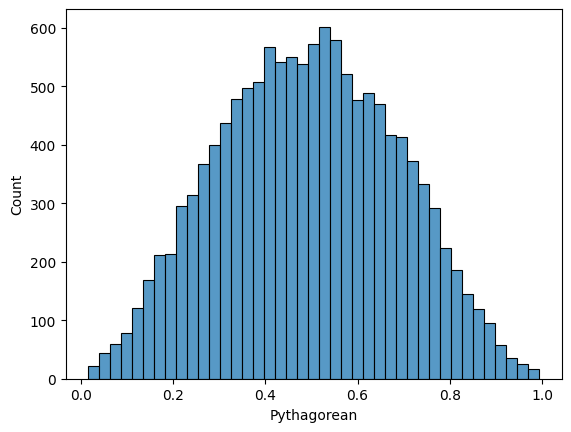

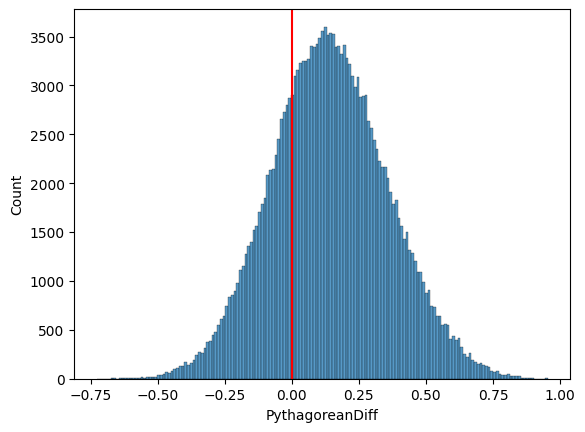

In [ ]:
# ===========================================================================================
# Pythagorean Wins/Losses
#    * Merges win margin and loss margin with df_features_season
# ===========================================================================================
total_points = total_points_scored.merge(total_points_allowed, how='outer')
total_points['Pythagorean'] = 1 / (1 + (total_points['PointsAllowed'] / total_points['PointsScored']) ** 8)

# The 8 is arbitrary (KenPom I think uses 11.5). I wanted something that would create a nice bell shaped curve like below.
sns.histplot(total_points['Pythagorean'])
plt.show()

df_season_condensed = df_season_results[['Season', 'WTeamID', 'LTeamID']].copy()

df_season_condensed_pyth = df_season_condensed.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, "W"])
df_season_condensed_pyth = df_season_condensed_pyth.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, 'L'])
df_season_condensed_pyth['PythagoreanDiff'] = df_season_condensed_pyth['Pythagorean'] - df_season_condensed_pyth['PythagoreanL']

sns.histplot(df_season_condensed_pyth['PythagoreanDiff'])
plt.axvline(0, color='red')
plt.show()

# Create Sabermetrics Data

###  Add KenPom features
* Tempo: We can estimate possessions very well from box score stats by using this formula: FGA-OR+TO+0.475xFTA.
For each team, possessions are counted for the team and their opponents, and then averaged. A team’s average tempo is total possessions divided by minutes. This value is then adjusted for schedule, considering the preferred pace of each opponent and when each game was played.
* Effective field goal percentage (eFG%): Computed from (FGM + 0.5*3PM)/FGA. This differs from conventional field goal percentage by taking into account the extra value of a made 3-pointer.
* Block%: Blocked shots / Opp. 2PA
* Steal%: Steals / Defensive possessions
* Offensive rebounding percentage: Computed from OR/(OR + DR). The value in the defensive column can be thought of as offensive rebounding percentage allowed.
Free throw rate: This is now FTA/FGA for both the offensive and defensive values.

In [ ]:
sabermetrics = pd.DataFrame()
sabermetrics_differences = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']
sabermetrics['Gender'] = df_season_results['Gender']

sabermetrics_differences['Season'] = df_season_results['Season']
sabermetrics_differences['WTeamID'] = df_season_results['WTeamID']
sabermetrics_differences['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .475 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .475 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Assist to Turnover Ratio
sabermetrics['WAssistTO'] = df_season_results['WAst'] / df_season_results['WTO']
sabermetrics['LAssistTO'] = df_season_results['LAst'] / df_season_results['LTO']

# Rebound Percentage
sabermetrics['WReboundPct'] = (df_season_results['WDR'] + df_season_results['WOR']) / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LReboundPct'] = (df_season_results['LDR'] + df_season_results['LOR']) / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Steal Block Foul Ratio (the plus 1's are for getting rid of infinity and 0 bounds)
sabermetrics['WStealBlockFoul'] = (df_season_results['WStl'] + df_season_results['WBlk'] + 10) / (df_season_results['WPF'] + 10)
sabermetrics['LStealBlockFoul'] = (df_season_results['LStl'] + df_season_results['LBlk'] + 10) / (df_season_results['LPF'] + 10)

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']

# Free Throw Percentage
sabermetrics['WFTPct'] = df_season_results['WFTM'] / df_season_results['WFTA']
sabermetrics['LFTPct'] = df_season_results['LFTM'] / df_season_results['LFTA']

#
# Adding KenPom features
#    Possessions = FGA-OR+TO+.475*FTA
#

# Field Goal (2pt + 3pt) Efficiency times the number of possessions
sabermetrics['WEFG_no'] = sabermetrics['WPossessions'] * (df_season_results['WFGM'] + 0.5*df_season_results['WFGM3']) / df_season_results['WFGA']
sabermetrics['LEFG_no'] = sabermetrics['LPossessions'] * (df_season_results['LFGM'] + 0.5*df_season_results['LFGM3']) / df_season_results['LFGA']

# Offensive Rebound Ratio times the number of possessions
sabermetrics['WOR_adv'] = sabermetrics['WPossessions'] * df_season_results['WOR']/(df_season_results['WOR'] + df_season_results['WDR'])
sabermetrics['LOR_adv'] = sabermetrics['LPossessions'] * df_season_results['LOR']/(df_season_results['LOR'] + df_season_results['LDR'])

# Defensive Rebound Ratio times the number of possessions
sabermetrics['WDR_adv'] = sabermetrics['WPossessions'] * df_season_results['WDR']/(df_season_results['WOR'] + df_season_results['WDR'])
sabermetrics['LDR_adv'] = sabermetrics['LPossessions'] * df_season_results['LDR']/(df_season_results['LOR'] + df_season_results['LDR'])

# Other Crosses I like

# Efficiency in Small Things Metric
sabermetrics['WEffSmall'] = sabermetrics['WAssistTO'] * sabermetrics['WFTPct']
sabermetrics['LEffSmall'] = sabermetrics['LAssistTO'] * sabermetrics['LFTPct']


#sabermetrics.info()

In [ ]:
# Fill in missing values
sabermetrics['WStealBlockFoul'].fillna(df_season_results['WStl'] + df_season_results['WBlk'], inplace=True)
sabermetrics.fillna(0, inplace=True)

# Differences (used for plotting below)
sabermetrics['PtsPerPossDiff'] = sabermetrics['WPtsPerPoss'] - sabermetrics['LPtsPerPoss']
sabermetrics['EffectiveFGPctDiff'] = sabermetrics['WEffectiveFGPct'] - sabermetrics['LEffectiveFGPct']
sabermetrics['AssistRateDiff'] = sabermetrics['WAssistRate'] - sabermetrics['LAssistRate']
sabermetrics['AssistTODiff'] = sabermetrics['WAssistTO'] - sabermetrics['LAssistTO']
sabermetrics['ReboundPctDiff'] = sabermetrics['WReboundPct'] - sabermetrics['LReboundPct']
sabermetrics['StealBlockFoulDiff'] = sabermetrics['WStealBlockFoul'] - sabermetrics['LStealBlockFoul']
sabermetrics['TORateDiff'] = sabermetrics['WTORate'] - sabermetrics['LTORate']
sabermetrics['BArcPctDiff'] = sabermetrics['WBArcPct'] - sabermetrics['LBArcPct']
sabermetrics['FTRateDiff'] = sabermetrics['WFTRate'] - sabermetrics['LFTRate']
sabermetrics['FTPctDiff'] = sabermetrics['WFTPct'] - sabermetrics['LFTPct']

sabermetrics['EFG_noDiff'] = sabermetrics['WEFG_no'] - sabermetrics['LEFG_no']
sabermetrics['OR_advDiff'] = sabermetrics['WOR_adv'] - sabermetrics['LOR_adv']
sabermetrics['DR_advDiff'] = sabermetrics['WDR_adv'] - sabermetrics['LDR_adv']
sabermetrics['EffSmallDiff'] = sabermetrics['WEffSmall'] - sabermetrics['LEffSmall']

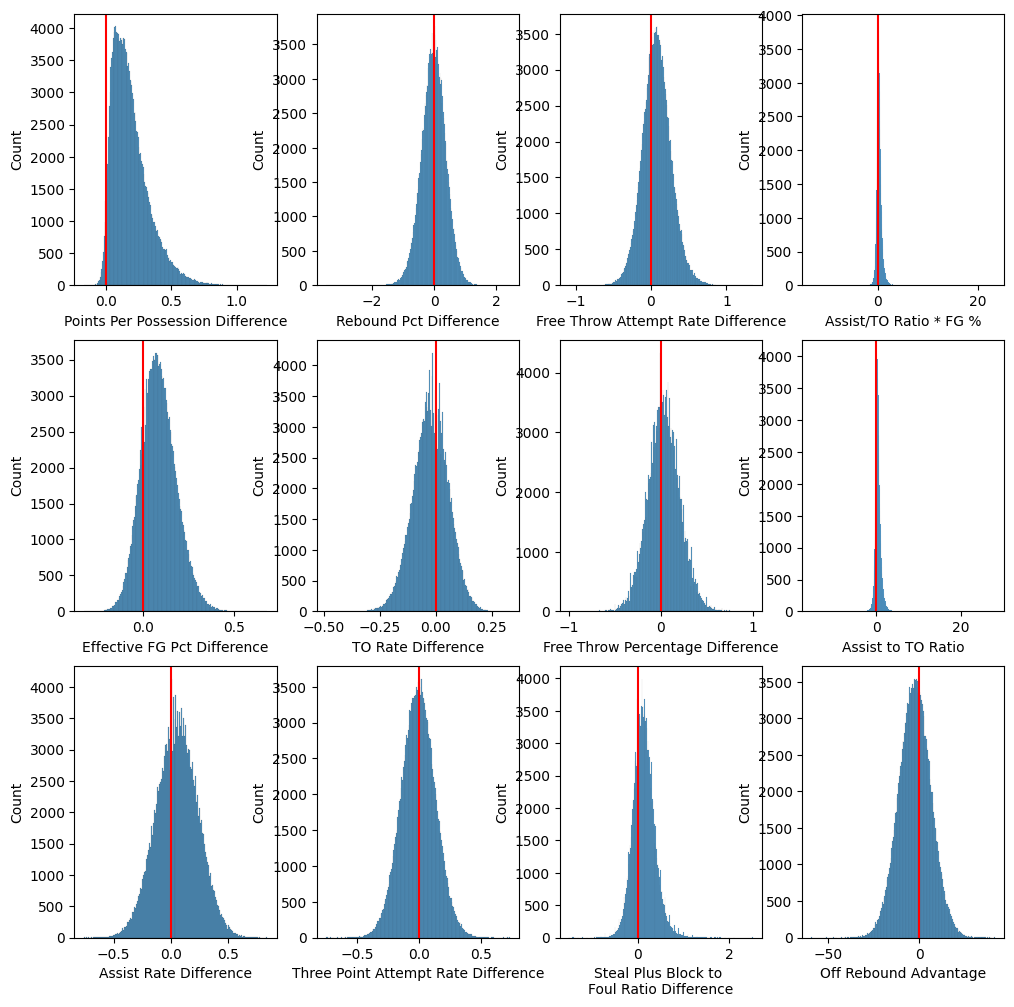

In [ ]:
figs, axs = plt.subplots(nrows=3, ncols=4, squeeze=True, figsize=(12, 12))

sns.histplot(sabermetrics['PtsPerPossDiff'], ax=axs[0, 0])
axs[0, 0].set_xlabel('Points Per Possession Difference')
axs[0, 0].axvline(0, color='red')

sns.histplot(sabermetrics['EffectiveFGPctDiff'], ax=axs[1, 0])
axs[1, 0].set_xlabel('Effective FG Pct Difference')
axs[1, 0].axvline(0, color='red')

sns.histplot(sabermetrics['AssistRateDiff'], ax=axs[2, 0])
axs[2, 0].set_xlabel('Assist Rate Difference')
axs[2, 0].axvline(0, color='red')

sns.histplot(sabermetrics['ReboundPctDiff'], ax=axs[0, 1])
axs[0, 1].set_xlabel('Rebound Pct Difference')
axs[0, 1].axvline(0, color='red')

sns.histplot(sabermetrics['TORateDiff'], ax=axs[1, 1])
axs[1, 1].set_xlabel('TO Rate Difference')
axs[1, 1].axvline(0, color='red')

sns.histplot(sabermetrics['BArcPctDiff'], ax=axs[2, 1])
axs[2, 1].set_xlabel('Three Point Attempt Rate Difference')
axs[2, 1].axvline(0, color='red')

sns.histplot(sabermetrics['FTRateDiff'], ax=axs[0, 2])
axs[0, 2].set_xlabel('Free Throw Attempt Rate Difference')
axs[0, 2].axvline(0, color='red')

sns.histplot(sabermetrics['FTPctDiff'], ax=axs[1, 2])
axs[1, 2].set_xlabel('Free Throw Percentage Difference')
axs[1, 2].axvline(0, color='red')

sns.histplot(sabermetrics['StealBlockFoulDiff'], ax=axs[2, 2])
axs[2, 2].set_xlabel('Steal Plus Block to \nFoul Ratio Difference')
axs[2, 2].axvline(0, color='red')

sns.histplot(sabermetrics['EffSmallDiff'], ax=axs[0, 3])
axs[0, 3].set_xlabel('Assist/TO Ratio * FG %')
axs[0, 3].axvline(0, color='red')

sns.histplot(sabermetrics['AssistTODiff'], ax=axs[1, 3])
axs[1, 3].set_xlabel('Assist to TO Ratio')
axs[1, 3].axvline(0, color='red')

sns.histplot(sabermetrics['OR_advDiff'], ax=axs[2, 3])
axs[2, 3].set_xlabel('Off Rebound Advantage')
axs[2, 3].axvline(0, color='red')

plt.show()

In [ ]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]

winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins', 'Gender']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses', 'Gender']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)

weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""

    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df


combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

metrics_list = ['PtsPerPoss', 'EffectiveFGPct', 'AssistRate', 'ReboundPct', 'TORate', 'BArcPct', 'FTRate', 'FTPct', 'StealBlockFoul', 'DR_adv', 'EFG_no', 'OR_adv', 'AssistTO', 'EffSmall']
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list

season_sabermetrics.index.columns = ['Season', 'TeamID']


<ipython-input-13-cf7793d4a390>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_columns.loc[:, 'Season'] = sabermetrics['Season']
<ipython-input-13-cf7793d4a390>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losing_columns.loc[:, 'Season'] = sabermetrics['Season']


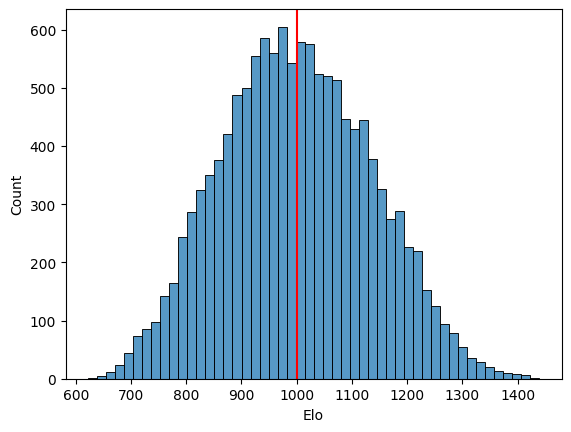

In [ ]:
def update_elo_scores(df, scores_dict, k=40):
    for index, row in df.iterrows():
        player1, player2 = str(row['WTeamID']), str(row['LTeamID'])
        if player1 not in scores_dict:
            scores_dict[player1] = 1000
        if player2 not in scores_dict:
            scores_dict[player2] = 1000
        score1, score2 = scores_dict[player1], scores_dict[player2]
        expected_score1 = 1 / (1 + 10 ** ((score2 - score1) / 400))
        expected_score2 = 1 / (1 + 10 ** ((score1 - score2) / 400))
        scores_dict[player1] = score1 + k * (1 - expected_score1)
        scores_dict[player2] = score2 + k * (0 - expected_score2)
    return scores_dict

all_seasons = dict()
scores_dict = dict()

for season in range(2003, 2025):
    df_season_condensed_year = df_season_condensed[df_season_condensed['Season'] == str(season)]
    scores_dict = update_elo_scores(df_season_condensed_year, scores_dict)
    all_seasons[str(season)] = scores_dict
    scores_dict = dict() # Reset dict for next season

elo_scores = pd.DataFrame(all_seasons)
elo_scores_unstacked = elo_scores.unstack().reset_index()
elo_scores_unstacked.columns = ['Season', 'TeamID', 'Elo']

sns.histplot(elo_scores_unstacked['Elo'])
plt.axvline(1000, color='red')
plt.show()

In [ ]:
pyth_trimmed = pd.DataFrame(total_points.set_index(['Season', 'TeamID'])['Pythagorean'])
elo_trimmed = elo_scores_unstacked.set_index(['Season', 'TeamID'])
df_features_season_trimmed = df_features_season.set_index(['Season', 'TeamID'])[['WinPct', 'AvgScoringMargin']]
all_statistics = pd.concat([pyth_trimmed, elo_trimmed, df_features_season_trimmed, season_sabermetrics], axis=1)

mm = MinMaxScaler() # This is preferred since our data is mostly normally distributed already.

all_statistics = pd.DataFrame(mm.fit_transform(all_statistics), columns = all_statistics.columns, index=all_statistics.index)

In [ ]:
winning_tourney_results = df_tourney_results[['Season', 'WTeamID', 'LTeamID', 'Gender']].merge(all_statistics,
                                                                                     left_on=['Season', 'WTeamID'],
                                                                                     right_index=True, how='left')
losing_tourney_results = df_tourney_results[['Season', 'WTeamID', 'LTeamID', 'Gender']].merge(all_statistics,
                                                                                    left_on=['Season', 'LTeamID'],
                                                                                    right_index=True, how='left')

# ===========================================================================================
# Combine the Winner results and the Loser results
#   * This creates an index of Season, WTeamID, and LTeamID
# ===========================================================================================
combined_tourney_results = pd.merge(left=winning_tourney_results,
                                    right=losing_tourney_results,
                                    on=['Season', 'WTeamID', 'LTeamID', 'Gender'],
                                    suffixes=['_W', '_L'])

# ===========================================================================================
# Add in seeds  by merging first with WTeamID and then with LTeamID
# ===========================================================================================
df_seeds[['Season', 'TeamID']] = df_seeds[['Season', 'TeamID']].astype(str)

combined_tourney_results = pd.merge(
    combined_tourney_results,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'Seed_W'})

combined_tourney_results = pd.merge(
    combined_tourney_results,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'Seed_L'})

combined_tourney_results.set_index(['Season', 'WTeamID', 'LTeamID', 'Gender'], inplace=True)

# ===========================================================================================
# Now take differences between the winners and losers in the combined tournament results
#    * This first pass is always Winner results minus Loser results.  The Label is set to 1.
# ===========================================================================================
df_tourney_features = pd.DataFrame(index=combined_tourney_results.index)
df_tourney_features['PtsPerPossDiff'] = combined_tourney_results['PtsPerPoss_W'] - combined_tourney_results['PtsPerPoss_L']
df_tourney_features['EffectiveFGPctDiff'] = combined_tourney_results['EffectiveFGPct_W'] - combined_tourney_results['EffectiveFGPct_L']
df_tourney_features['AvgScoringMarginDiff'] = combined_tourney_results['AvgScoringMargin_W'] - combined_tourney_results['AvgScoringMargin_L']
df_tourney_features['AssistRateDiff'] = combined_tourney_results['AssistRate_W'] - combined_tourney_results['AssistRate_L']
df_tourney_features['AssistTODiff'] = combined_tourney_results['AssistTO_W'] - combined_tourney_results['AssistTO_L']
df_tourney_features['ReboundPctDiff'] = combined_tourney_results['ReboundPct_W'] - combined_tourney_results['ReboundPct_L']
df_tourney_features['StealBlockFoulDiff'] = combined_tourney_results['StealBlockFoul_W'] - combined_tourney_results['StealBlockFoul_L']
df_tourney_features['TORateDiff'] = combined_tourney_results['TORate_W'] - combined_tourney_results['TORate_L']
df_tourney_features['BArcPctDiff'] = combined_tourney_results['BArcPct_W'] - combined_tourney_results['BArcPct_L']
df_tourney_features['FTRateDiff'] = combined_tourney_results['FTRate_W'] - combined_tourney_results['FTRate_L']
df_tourney_features['FTPctDiff'] = combined_tourney_results['FTPct_W'] - combined_tourney_results['FTPct_L']
df_tourney_features['WinPctDiff'] = combined_tourney_results['WinPct_W'] - combined_tourney_results['WinPct_L']
df_tourney_features['EloDiff'] = combined_tourney_results['Elo_W'] - combined_tourney_results['Elo_L']
df_tourney_features['DR_advDiff'] = combined_tourney_results['DR_adv_W'] - combined_tourney_results['DR_adv_L']
df_tourney_features['EFG_noDiff'] = combined_tourney_results['EFG_no_W'] - combined_tourney_results['EFG_no_L']
df_tourney_features['OR_advDiff'] = combined_tourney_results['OR_adv_W'] - combined_tourney_results['OR_adv_L']
df_tourney_features['EffSmallDiff'] = combined_tourney_results['EffSmall_W'] - combined_tourney_results['EffSmall_L']
df_tourney_features['PythagoreanDiff'] = combined_tourney_results['Pythagorean_W'] - combined_tourney_results['Pythagorean_L']
#df_tourney_features['Gender'] = combined_tourney_results['Gender'].values
df_tourney_features['SeedDiff'] = combined_tourney_results['Seed_W'].astype(int) - combined_tourney_results['Seed_L'].astype(int)
df_tourney_features['ScoreDiff'] = (df_tourney_results['WScore'] - df_tourney_results['LScore']).values
df_tourney_features['WinA'] = (df_tourney_features['ScoreDiff'] > 0).astype(int) # This sets WinA to 1 for the Winners
df_tourney_features.index.rename(['Season', 'TeamA', 'TeamB', 'Gender'], inplace=True)
df_tourney_features.info()
df_tourney_features

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2142 entries, ('2003', '1421', '1411', 1) to ('2023', '3261', '3234', 0)
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PtsPerPossDiff        2142 non-null   float64
 1   EffectiveFGPctDiff    2142 non-null   float64
 2   AvgScoringMarginDiff  2142 non-null   float64
 3   AssistRateDiff        2142 non-null   float64
 4   AssistTODiff          2142 non-null   float64
 5   ReboundPctDiff        2142 non-null   float64
 6   StealBlockFoulDiff    2142 non-null   float64
 7   TORateDiff            2142 non-null   float64
 8   BArcPctDiff           2142 non-null   float64
 9   FTRateDiff            2142 non-null   float64
 10  FTPctDiff             2142 non-null   float64
 11  WinPctDiff            2142 non-null   float64
 12  EloDiff               2142 non-null   float64
 13  DR_advDiff            2142 non-null   float64
 14  EFG_noDiff            2

PtsPerPossDiff  EffectiveFGPctDiff  AvgScoringMarginDiff  AssistRateDiff  AssistTODiff  ReboundPctDiff  StealBlockFoulDiff  TORateDiff  BArcPctDiff  FTRateDiff  FTPctDiff  WinPctDiff   EloDiff  DR_advDiff  EFG_noDiff  OR_advDiff  EffSmallDiff  PythagoreanDiff  SeedDiff  ScoreDiff  WinA
Season TeamA TeamB Gender                                                                                                                                                                                                                                                                                                
2003   1421  1411  1            -0.028007           -0.042509             -0.122313       -0.111577     -0.026437       -0.057728            0.019070    0.051128    -0.032734   -0.324420   0.446203   -0.151724 -0.038083   -0.007925   -0.041665    0.006910      0.042312        -0.244493         0          8     1
       1112  1436  1             0.124499            0.073550              0.136938        0.025667      0.085440       -0.088086            0.027277   -0.089701     0.053723    0.067516   0.150629    0.237685  0.205990    0.180140    0.256757    0.152920      0.104203         0.189790       -15         29     1
       1113  1272  1             0.058237            0.061016             -0.025192       -0.126749     -0.035508        0.029403           -0.081908    0.025742    -0.229855    0.153260   0.138691   -0.172414 -0.135940   -0.069618    0.024769    0.033676      0.014720        -0.051552         3         13     1
       1141  1166  1            -0.066483            0.017282             -0.116967        0.011853     -0.180119       -0.001989           -0.089522    0.238125    -0.023349    0.272036   0.213836   -0.085684 -0.044202    0.076589    0.067197    0.014034     -0.119982        -0.190602         5          6     1
       1143  1301  1            -0.030791           -0.032413              0.004306       -0.037345      0.050633       -0.011663           -0.009489   -0.045639    -0.269679   -0.083482  -0.262094    0.124138  0.019089    0.054235    0.040588    0.049127     -0.013221         0.005419        -1          2     1
...                                   ...                 ...                   ...             ...           ...             ...                 ...         ...          ...         ...        ...         ...       ...         ...         ...         ...           ...              ...       ...        ...   ...
2023   3376  3268  0             0.158235            0.043066              0.268945       -0.077101      0.005203        0.175339            0.092507   -0.000458    -0.158568    0.115933  -0.303992    0.193548  0.162887   -0.247074   -0.046031    0.078579     -0.065462         0.232546        -1         11     1
       3439  3326  0             0.018442           -0.006864              0.039207        0.017645     -0.052761        0.026155           -0.119859    0.039472     0.094535    0.002151   0.152732    0.089718  0.134635   -0.173269   -0.165991   -0.100116     -0.018295         0.080186        -2         10     1
       3234  3376  0            -0.012380            0.240445             -0.188041        0.258732      0.065826       -0.183551           -0.154473    0.023601     0.347457   -0.035209   0.226023   -0.187500 -0.123141    0.505263    0.312211   -0.274269      0.110948        -0.142721         1          4     1
       3261  3439  0             0.092970           -0.030331              0.144987       -0.230178     -0.071039        0.176839            0.135478    0.014858    -0.316469    0.185206  -0.168355    0.062366 -0.021680   -0.048299    0.096577    0.229609     -0.099019         0.083018         2          7     1
             3234  0            -0.020400           -0.226597              0.135212       -0.400645     -0.179858        0.210498            0.097764    0.034671    -0.317655    0.118277  -0.233324    0.120833  0.004525   -0.423708   -0.235952    0.302068    

# Flip the datasets to effectively double the data

* Next we add in the Label (WinA) and set it to 0 because we now have the difference with Losers first.

In [ ]:
df_tourney_features_symmetrical = df_tourney_features.copy()
df_tourney_features_symmetrical.index.rename(['Season', 'TeamB', 'TeamA', 'Gender'], inplace=True)
df_tourney_features_symmetrical = df_tourney_features_symmetrical * -1
#df_tourney_features_symmetrical['Gender'] = df_tourney_features_symmetrical['Gender'] * -1 # Lazy way to reverse any prior changes
df_tourney_features_symmetrical['WinA'] = 0
df_tourney_features_combined = pd.concat([df_tourney_features, df_tourney_features_symmetrical], axis=0)

df_tourney_features_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4284 entries, ('2003', '1421', '1411', 1) to ('2023', '3261', '3234', 0)
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PtsPerPossDiff        4284 non-null   float64
 1   EffectiveFGPctDiff    4284 non-null   float64
 2   AvgScoringMarginDiff  4284 non-null   float64
 3   AssistRateDiff        4284 non-null   float64
 4   AssistTODiff          4284 non-null   float64
 5   ReboundPctDiff        4284 non-null   float64
 6   StealBlockFoulDiff    4284 non-null   float64
 7   TORateDiff            4284 non-null   float64
 8   BArcPctDiff           4284 non-null   float64
 9   FTRateDiff            4284 non-null   float64
 10  FTPctDiff             4284 non-null   float64
 11  WinPctDiff            4284 non-null   float64
 12  EloDiff               4284 non-null   float64
 13  DR_advDiff            4284 non-null   float64
 14  EFG_noDiff            4

In [ ]:
n_rows = 5; n_cols = 4
figs, axs = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=True, figsize=(16, 16))

row = 0; col = 0
for feature in df_tourney_features.columns[:-2]:
    sns.histplot(df_tourney_features[feature], ax=axs[row, col])
    axs[row, col].set_xlabel(feature)
    axs[row, col].axvline(0, color='red')
    row += 1
    if row == n_rows:
        row = 0
        col += 1

plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df_tourney_features_combined.corr(), annot=True)
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

X_mi = df_tourney_features_combined.drop(['WinA', 'ScoreDiff'], axis=1)
y_mi = df_tourney_features_combined['WinA']
mi_scores = make_mi_scores(X_mi, y_mi)
f, ax = plt.subplots(figsize=(10, 10))
plot_mi_scores(mi_scores)

In [ ]:
df_tourney_features_combined[features_noseed].to_pickle(X_NOSEED_OUTPUT)
df_tourney_features_combined[features_seed].to_pickle(X_SEED_OUTPUT)
df_tourney_features_combined[target].to_pickle(LABEL_OUTPUT)
all_statistics.to_pickle(ALL_STATISTICS_OUTPUT) # Output so we can create the inference data using Kaggle's submission form.

# TRAINING VALIDATION

In [ ]:
from pickle import FALSE
mod_type = 'no_seed' # 'seed' or 'no_seed'
optimize = False
train = True

with open(MteamDict_OUTPUT, 'rb') as f:
    mTeamDict = pickle.load(f)

with open(WteamDict_OUTPUT, 'rb') as f:
    wTeamDict = pickle.load(f)

if mod_type == 'no_seed':
    X = pd.read_pickle(X_NOSEED_OUTPUT)
    features = features_noseed
elif mod_type == 'seed':
    X = pd.read_pickle(X_SEED_OUTPUT)
    features = features_seed
else:
    print('mod_type is not set')
MteamDict = pd.read_pickle(MteamDict_OUTPUT)
WteamDict = pd.read_pickle(WteamDict_OUTPUT)

y = np.ravel(pd.read_pickle(LABEL_OUTPUT).values)
X_t = X.reset_index() # Flatten the Multi-index

logo = LeaveOneGroupOut()
X_scaled = X_t[features]
groups = X_t['Gender'].values

X_scaled.set_index(groups, inplace=True)

In [ ]:
def objective(trial):
    lgbm_params = {
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-6, 1e2, log=True),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e0, 1e3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 64),
        'learning_rate': trial.suggest_float("learning_rate", 0, .5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', .5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', .5, 1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 80),
    }
    return score_dataset(X_scaled, y, lgbm_params)

def score_dataset(X_scaled, y, lgbm_params):

    classifier = lgb.LGBMClassifier(**lgbm_params, class_weight='balanced')

    score = cross_val_score(classifier, X_scaled, y.ravel(), cv=logo, groups=groups, scoring='neg_brier_score')
    score = -1 * score.mean()
    return score
if optimize:
    study = optuna.create_study()
    study.optimize(objective, n_trials=80)
    lgbm_params = study.best_params
    print(lgbm_params)

    plot_slice(study)

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()
else:
    lgbm_params = {'reg_alpha': 8.798961125162398e-05, 'reg_lambda': 66.78655829939625, 'num_leaves': 902,
                   'max_depth': 2, 'learning_rate': 0.4139271948057302, 'colsample_bytree': 0.6265689754049907,
                   'colsample_bynode': 0.7481827600398412, 'n_estimators': 62}

In [ ]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 32),
        learning_rate=trial.suggest_float("learning_rate", 0, 1),
        n_estimators=trial.suggest_int("n_estimators", 30, 80),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1),
        colsample_bynode=trial.suggest_float("colsample_bynode", 0.01, 1),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.01, 1),
        max_delta_step=trial.suggest_int("max_delta_step", 1, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e-1, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e0, 1e3, log=True),
        gamma=trial.suggest_float("gamma", 1e-6, 1, log=True)

    )
    return score_dataset(X_scaled, y, xgb_params)

def score_dataset(X_scaled, y, xgb_params):

    classifier = xgb.XGBClassifier(**xgb_params)

    score = cross_val_score(classifier, X_scaled, y, cv=logo, groups=groups, scoring='neg_brier_score')
    score = -1 * score.mean()
    return score
if optimize:
    study = optuna.create_study()
    study.optimize(objective, n_trials=80)
    xgb_params = study.best_params
    print(xgb_params)

    plot_slice(study)
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()
else:
    #xgb_params = {'max_depth': 19, 'learning_rate': 0.9687302532713133, 'n_estimators': 40,
    #              'min_child_weight': 5, 'colsample_bytree': 0.08845826230565196,
    #              'colsample_bynode': 0.08063547698789597, 'colsample_bylevel': 0.38854855900542506,
    #              'max_delta_step': 9, 'reg_alpha': 0.00016069314717976713, 'reg_lambda': 326.8808282490097, 'gamma': 0.12027113040083756}

    xgb_params = {'max_depth': 31, 'learning_rate': 0.10340708820457713, 'n_estimators': 31,
                  'min_child_weight': 10, 'colsample_bytree': 0.8980917155835416, 'colsample_bynode': 0.7211932283675185,
                  'colsample_bylevel': 0.8228641573523129, 'max_delta_step': 10, 'reg_alpha': 0.06871582194946087,
                  'reg_lambda': 4.243530996037945, 'gamma': 8.122361408059115e-05}

In [ ]:
def objective(trial):
    rf_params = dict(
        max_depth=trial.suggest_int("max_depth", 1, 16),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 16),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 16),
        max_features=trial.suggest_categorical("max_features", [None, 'sqrt', 'log2']),
        n_estimators=trial.suggest_int("n_estimators", 100, 1800, step=100),
        criterion=trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
        class_weight=trial.suggest_categorical("class_weight", ['balanced', 'balanced_subsample', None]),
        )


    return score_dataset(X_scaled, y, rf_params)

def score_dataset(X_scaled, y, rf_params):

    classifier = RandomForestClassifier(**rf_params)

    score = cross_val_score(classifier, X_scaled, y, cv=logo, groups=groups, scoring='neg_brier_score')
    score = -1 * score.mean()
    return score
if optimize:
    study = optuna.create_study()
    study.optimize(objective, n_trials=40)
    rf_params = study.best_params
    print(rf_params)

    plot_slice(study)
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()
else:
    #rf_params = {'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 15, 'max_features': 'sqrt',
    #             'n_estimators': 640, 'criterion': 'entropy', 'bootstrap': True, 'class_weight': 'balanced_subsample'}
    rf_params =  {'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 6, 'max_features': None, 'n_estimators': 1200,
                  'criterion': 'log_loss', 'bootstrap': True, 'class_weight': None}

In [ ]:
from warnings import WarningMessage
#model_nn= MLPClassifier(solver='adam', alpha=1e-5, warm_start = True, shuffle=True, hidden_layer_sizes=(20,10))

def objective(trial):

    nn_params = {
        'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.0001, 0.1, step=0.005),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=10),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=10),
        'third_layer_neurons': trial.suggest_int('third_layer_neurons', 5, 50, step=5),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
    }

    model = MLPClassifier(
        hidden_layer_sizes=(nn_params['first_layer_neurons'], nn_params['second_layer_neurons'], nn_params['third_layer_neurons']),
        learning_rate_init=nn_params['learning_rate_init'],
        activation=nn_params['activation'],
        warm_start=True,
        shuffle=True,
        solver=nn_params['solver'],
        random_state=1,
        max_iter=500
    )

    model.fit(X_scaled, y)

    return mean_squared_error(y, model.predict(X_scaled), squared=False)

if optimize:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)
    nn_params = study.best_params
    print("BEST PARAMS", nn_params)

    plot_slice(study)
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()
else:
    #nn_params = {'learning_rate_init': 0.0101, 'hidden_layer_sizes': (70,60), 'warm_start':True,
    #    'shuffle':True, 'solver': 'adam', 'activation': 'relu', 'max_iter':500}
    nn_params =  {'learning_rate_init ': 0.0451, 'hidden_layer_sizes': (40,50,30), 'warm_start':True,
                  'shuffle':True, 'solver': 'lbfgs', 'activation': 'tanh', 'max_iter':500}

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

def get_scaled_data(X, y, features):
    #mm = MinMaxScaler() # This is preferred since our data is mostly normally distributed already.
    X_train_test = X[X.Season.astype(int) < 2023].reset_index(drop=True).copy()
    X_21 = X[X.Season.astype(int) == 2021].reset_index(drop=True).copy()
    X_22 = X[X.Season.astype(int) == 2022].reset_index(drop=True).copy()
    X_train_test = pd.concat([X_train_test, X_21, X_22], axis=0)
    X_inf = X[X.Season.astype(int) == 2023].reset_index(drop=True).copy()
    y_train_test = y[X.Season.astype(int) < 2023]
    y_21 = y[X.Season.astype(int) == 2021]
    y_22 = y[X.Season.astype(int) == 2022]
    y_train_test = np.concatenate((y_train_test, y_21, y_22), axis=0)
    y_inf = y[X.Season.astype(int) == 2023]

    #
    # This is wrong.  X_inf could be used as a validation set, but is not the inference data.
    # Need to build inference data from the season results, not tourney results.  TBD.

    return X_train_test[features], X_inf[features], y_train_test, y_inf, X_inf

def get_data_full_model(X, y, year, features):
    X_train_test = X[X.Season.astype(int) < year].reset_index(drop=True).copy()
    X_21 = X[X.Season.astype(int) == year-3].reset_index(drop=True).copy()
    X_22 = X[X.Season.astype(int) == year-2].reset_index(drop=True).copy()
    X_train_test = pd.concat([X_train_test, X_21, X_22], axis=0)
    X_inf = X[X.Season.astype(int) == year-1].reset_index(drop=True).copy()
    y_train_test = y[X.Season.astype(int) < year]
    y_21 = y[X.Season.astype(int) == year-3]
    y_22 = y[X.Season.astype(int) == year-2]
    y_train_test = np.concatenate((y_train_test, y_21, y_22), axis=0)
    y_inf = y[X.Season.astype(int) == year-1]
    return X_train_test[features], X_inf[features], y_train_test, y_inf, X_inf

def kfold_reg(X_train_test, y_train, plot=False, verbose=0, mode="reg"):
    cvs = []
    nn_params = {'learning_rate_init': 0.0101, 'hidden_layer_sizes': (70,60), 'warm_start':True,
        'shuffle':True, 'solver': 'adam', 'activation': 'relu'}

    target = "ScoreDiff" if mode == "reg" else "WinA"

    #
    # Train the Model
    #

    if mode == "reg":
        model = ElasticNet(alpha=1, l1_ratio=0.5)
    else:
        logistic = LogisticRegression(max_iter=10000, class_weight='balanced')
        lsvc = LinearSVC(C=100, max_iter=100000, class_weight='balanced') # I snuck this in because it did really well in validation testing.
        xgbc = xgb.XGBClassifier(**xgb_params)
        lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight='balanced')
        model_rf = RandomForestClassifier(**rf_params)
        #      Multi-layer Perceptron (neural net)
        model_nn= MLPClassifier(**nn_params, learning_rate='adaptive')

        stacked = StackingClassifier(estimators=[
                                                    ('LinearSVC', lsvc),
                                                    ('RandomForest', model_rf),
                                                    ('NeuralNet', model_nn),
                                                    ('XGBoost', xgbc),
                                                    ('LightGBM', lgbm)],
                                                    final_estimator=logistic)
        model = stacked

    model.fit(X_train_test, y_train)

    return model



def verify(X_inf, y_inf, plot=False, verbose=0, mode="reg"):
    """ Just pick a year to verify model results on.  2023 works well now
    """
    # load pickled model
    cvs = []
    with open(MODEL_OUTPUT, 'rb') as f:
        clf = pickle.load(f)

    pred = clf.predict_proba(X_inf)

    # pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())


    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(pred, y_inf.values, s=5)
        plt.grid(True)
        plt.subplot(1, 2, 2)
        sns.histplot(pred[:,1])
        plt.show()



    loss = ((y_inf - pred[:,1]) ** 2).mean()
    cvs.append(loss)
    print(f'\t -> Loss (rms) {loss:.4f}')

    print(f'Model Score: {clf.score(X_inf, y_inf):.4f}')
    #print(f'Cohens Kappa Score: {cohen_kappa_score(X_inf, y_inf):.4f}')
    #print(classification_report(X_inf, y_inf))
    #print(confusion_matrix(y_inf, pred))
    #print(f'\n Local CV is {np.mean(cvs):.4f}')

    return pred

In [ ]:
X_train_test, X_inf, y_train_test, y_inf, X_inf_all = get_scaled_data(X_t, y, features)
print(len(features), len(X_train_test))
if train:
    model = kfold_reg(X_train_test, y_train_test, plot=True, verbose=1, mode="none")
    calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    calibrated.fit(X_inf, y_inf)
    #
    # Pickle the Model
    #
    with open(MODEL_OUTPUT,'wb') as f:
        pickle.dump(calibrated,f)
pred_test = verify(X_inf, y_inf, plot=False, verbose=0, mode="none")
#
# Now retrain the model to pull in the previous year's data
#
X_train_test, X_inf, y_train_test, y_inf, X_inf_all = get_data_full_model(X_t, y, 2024, features)
if train:
    model = kfold_reg(X_train_test, y_train_test, plot=True, verbose=1, mode="none")
    calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    calibrated.fit(X_inf, y_inf)
    #
    # Pickle the Model
    #
    with open(MODEL_OUTPUT,'wb') as f:
        pickle.dump(calibrated,f)

In [ ]:
m_results_23 = [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1]

display(X_inf.head())
df_test = pd.DataFrame()
df_test['teamA'] = X_inf_all.TeamA
df_test['teamB'] = X_inf_all.TeamB
df_test['Gender'] = X_inf_all.Gender
df_test['pred'] = pred_test[:,1]
fil_m = df_test['Gender'] == 1
fil_w = df_test['Gender'] == 0
df_test_m = df_test[fil_m]
df_test_w = df_test[fil_w]
df_test_m['teamNameA'] = df_test_m['teamA'].astype(int).map(mTeamDict)
df_test_m['teamNameB'] = df_test_m['teamB'].astype(int).map(mTeamDict)
df_test_w['teamNameA'] = df_test_w['teamA'].astype(int).map(wTeamDict)
df_test_w['teamNameB'] = df_test_w['teamB'].astype(int).map(wTeamDict)
df_test_m = df_test_m[0:67]
df_test_w = df_test_w[0:67]
#
#  Better to do this after building 2024 inference dataset based on 2024 season stats
#  for each team.  Then this output file would be used in the building of the Kaggle outputs.
#

df_test_m.Results = m_results_23
#display(df_test_m.head())
df_test_m.Error = df_test_m.pred - df_test_m.Results
print("RESULTS on 2023 Men's Bracket Error/STD")
print(df_test_m.Error.mean(), df_test_m.Error.std())
df_test_m.to_csv(f'{DATA_FOLDER}mens_probabilities.csv', index=False)
df_test_w.to_csv(f'{DATA_FOLDER}womens_probabilities.csv', index=False)
df_test_m

In [ ]:
from tqdm import tqdm

class QuickTourneySimulator(object):
    def __init__(self, fname_slots, features, model, seed_dict, TeamDict):
        self.fname_slots = fname_slots
        self.df_slots = self._make_df_slots(self.fname_slots)
        self.rng = np.random.default_rng()
        self.features = features
        self.model = model
        self.seed_dict = seed_dict
        self.TeamDict = TeamDict

    @staticmethod
    def _make_df_slots(fname_slots):
        '''Reduced version of dataframe containing the slots information
        Parameters
        ----------
        fname_slots : str
            path to the file containing tournament Slots info
            Mens or Womens tournament should result in the same output here

        Returns
        -------
        df_slots : pandas DataFrame
            Slots info for NCAA tournament for Round 1 and later

        '''
        df_slots = pd.read_csv(fname_slots)

        # Only keep slots that are part of the traditional
        # tournament (no play-ins)
        df_slots = df_slots[df_slots['Slot'].str.startswith('R')]

        # except for play-ins (which we don't care about)
        # the tournament is the same structure every year
        # So, drop Season column and duplicate Slot entries
        df_slots.drop_duplicates('Slot', inplace=True)
        df_slots.drop(columns='Season', inplace=True)
        return df_slots

    def simulate(self, prob_func, **prob_func_kwargs):
        ''' Simulates a tournament for a given function that
        assigns probabilities to the games

        Parameters
        ----------
        prob_func: func
            Takes two arguments: seed1 and seed2 in format like 'W01' or X13', etc.
            Result should be the probability that seed1 beats seed2
        prob_func_kwargs: dict
            key word arguments for prob_func

        Returns
        -------
        df_tourney: pandas DataFrame
            Single simulated tournament with columns 'Slot' and 'Team'
        '''
        seeds = [f'{region}{num:02d}' for region in list('WXYZ') \
                 for num in range(1,17)]
        # Seeds is an array from W01 to Z16.
        # Possibly here map the W01 to the Team ID in a dictionary

        tourney = {s:s for s in seeds}

        #
        # Go through the matchups and predict which team wins.
        #
        for sl, ss, ws in zip(self.df_slots['Slot'],
                              self.df_slots['StrongSeed'],
                              self.df_slots['WeakSeed']):
            # probability that strong seed wins
            ssID = self.seed_dict[tourney[ss]]
            # probability that weak seed wins
            wsID = self.seed_dict[tourney[ws]]


            prob = prob_func(ssID, wsID, self.features, self.model, **prob_func_kwargs)

            result = (self.rng.random() < prob[:,1]) # This should do well on the probs near 50%
            line = f"{result[0]}, {prob[:,0][0]}, {prob[:,1][0]}, {ssID}, {wsID}, {ss}, {ws}, {self.TeamDict[ssID]}, {self.TeamDict[wsID]}\n"
            with open(f"{OUTPUT_FOLDER}inf_results.csv", "a") as myfile:
                myfile.write(line)
            # Here we build out the dictionary of slot_winner:winning_team
            if result == 0:
                tourney[sl] = tourney[ws]
            else:
                tourney[sl] = tourney[ss]

        df_tourney = pd.DataFrame({'Slot': tourney.keys(), 'Team': tourney.values()})
        df_tourney = df_tourney[df_tourney['Slot'].str.startswith('R')]
        return df_tourney.reset_index(drop=True)

    def simulate_multiple(self, n, prob_func, **prob_func_kwargs):
        ''' Simulates a multiple tournaments for a given function that
        assigns probabilities to the games

        Parameters
        ----------
        n: int
            number of simulations to perform
        prob_func: func
            Takes two arguments: seed1 and seed2 in format like 'W01' or X13', etc.
            Result should be the probability that seed1 beats seed2
        prob_func_kwargs: dict
            key word arguments for prob_func

        Returns
        -------
        df_out: pandas DataFrame
            n simulated tournaments with columns 'Bracket', Slot', and 'Team'
        '''
        df_out = []
        for i in tqdm(range(n)): # for each simulated bracket
            df = self.simulate(prob_func, **prob_func_kwargs)
            df['Bracket'] = i
            df_out.append(df)
        df_out = pd.concat(df_out)
        return df_out.reset_index(drop=True)


def prob_simple_seed_model(seed1, seed2, **kwargs):
    '''What I want to do here is do inference on the model for the two seeds passed in.
    Probably need to convert between slot identifier (W01) and team ID here because that's
    how my model is set up.
    '''
    # prob that seed1 wins
    # Convert seed1 and seed2 to the TeamID 1 and Team ID 2 here.
    int_seed1 = int(seed1[1:]) # this is just for the the silly seed model.
    int_seed2 = int(seed2[1:])
    # want to return the likelihood from inference.
    return 0.5 + 0.03*(int_seed2 - int_seed1)


"""
Here we need to get the teams in the tournament, the slot numbers, seeds, etc., then calculate their stats for 2024 season.
As we pick two teams at a time to compare, build the diffs, double the data, then do inference two at a time.
"""

# Open the season statistics pickle from the EDA notebook
with open(ALL_STATISTICS_OUTPUT, 'rb') as f:
    all_stats = pickle.load(f)

#mm = MinMaxScaler() # This is preferred since our data is mostly normally distributed already.
all_stats_sub = all_stats.reset_index().copy()

def get_inference_probs(teamA, teamB, final_features, model):
    submission = pd.DataFrame([[str(teamA), str(teamB), "2024"]], columns=['TeamA', 'TeamB', 'Season'])
    teamA_stats = submission.merge(all_stats_sub, left_on=['Season', 'TeamA'], right_on=['Season', 'level_1'])
    teamB_stats = submission.merge(all_stats_sub, left_on=['Season', 'TeamB'], right_on=['Season', 'level_1'])
    merged_team_stats = teamA_stats.merge(teamB_stats, on=['Season', 'TeamA', 'TeamB'], suffixes=['_A', '_B'])
    X_test = pd.DataFrame()

    for feature in final_features:
        X_test[feature] = merged_team_stats[feature[:-4] + '_A'] - merged_team_stats[feature[:-4] + '_B']
    X_test = X_test[final_features]
    #X_test['SeedDiff'] = 0 # We don't have seeds yet.

    pred = model.predict_proba(X_test)
    return pred

In [ ]:
with open(MODEL_OUTPUT, 'rb') as f:
        clf = pickle.load(f)

seed_df = pd.read_csv(f'{DATA_FOLDER}2024_tourney_seeds.csv')

p_func = get_inference_probs

n_brackets_per_tournament = 5
df_submission = []
for tournament in ['M','W']:
    seed_fil = seed_df['Tournament'] == tournament
    seed_df_tournament = seed_df[seed_fil]
    seed_dict = dict(zip(seed_df_tournament['Seed'], seed_df_tournament['TeamID']))
    if tournament == 'M':
        TeamDict = mTeamDict
    else:
        TeamDict = wTeamDict

    qts = QuickTourneySimulator(f'{DATA_FOLDER}{tournament}NCAATourneySlots.csv', features_noseed, clf, seed_dict, TeamDict)
    #qts = QuickTourneySimulator('/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySlots.csv')
    tmp = qts.simulate_multiple(n_brackets_per_tournament,p_func)
    tmp['Tournament'] = tournament
    df_submission.append(tmp)

df_submission = pd.concat(df_submission)

# add RowId column
df_submission['RowId'] = np.arange(df_submission.shape[0])
# reorder columns
df_submission = df_submission[['RowId','Tournament','Bracket','Slot','Team']]
# write out for submission
df_submission.to_csv(f'{OUTPUT_FOLDER}submission.csv',index=False)